In [1]:
# in terminal
'''
mongoimport --type json -d texasSchoolsDB -c scores_finances --drop --jsonArray scores_finances.json
mongoimport --type json -d texasSchoolsDB -c school_info --drop --jsonArray texas-school.json
mongoimport --type json -d texasSchoolsDB -c coordinates --drop --jsonArray finance_coordinates.json
mongoimport --type json -d texasSchoolsDB -c scores_finances_coordinates --drop --jsonArray finance_scores_coordinates.json
mongoimport --type json -d texasSchoolsDB -c schools_2022_to_2023_geojson --drop --jsonArray Schools_2022_to_2023.json
mongoimport --type json -d texasSchoolsDB -c demographics --drop --jsonArray demographics.json
mongoimport --type json -d texasSchoolsDB -c current_districts_geojson --drop --jsonArray Current_Districts_2023 .geojson
jq --compact-output ".features" Current_Districts_2023.geojson | mongoimport --db texasSchoolsDB -c current_districts_geojson --jsonArray
'''

'\nmongoimport --type json -d texasSchoolsDB -c scores_finances --drop --jsonArray scores_finances.json\nmongoimport --type json -d texasSchoolsDB -c school_info --drop --jsonArray texas-school.json\nmongoimport --type json -d texasSchoolsDB -c coordinates --drop --jsonArray finance_coordinates.json\nmongoimport --type json -d texasSchoolsDB -c scores_coordinates --drop --jsonArray finance_scores_coordinates.json\n\n\n'

In [1]:
from pymongo import MongoClient
import json
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from branca.colormap import linear

In [2]:
mongo = MongoClient(port=27017)

In [3]:
for dbname in mongo.list_database_names():
    if dbname == "texasSchoolsDB":
        print(f'{dbname} <----------')
    else:
        print(dbname)

admin
autosaurus
classDB
config
epa
fruits_db
garden_db
local
met
petsitly_marketing
test
texasSchoolsDB <----------
travel_db
uk_food


In [4]:
db = mongo["texasSchoolsDB"]

In [5]:
db.list_collection_names()

['coordinates',
 'scores_finances_coordinates',
 'scores_coordinates',
 'schools_2022_to_2023_geojson',
 'school_info',
 'current_districts_geojson',
 'scores_finances']

In [6]:
coordinates = db.coordinates

In [7]:
scores = db.scores_coordinates

In [10]:
# Create a Folium map
map = folium.Map(location=[29.7604, -95.3698], zoom_start=6)

# Create a feature group for the markers
marker_group = folium.FeatureGroup(name='Markers')

# Fetch data from MongoDB and create markers
for document in coordinates.find({}):
    latitude = float(document.get('Latitude'))  # Convert to float
    longitude = float(document.get('Longitude'))  # Convert to float
    revenue = float(document.get('Total_Operating_Revenue'))  # Convert to int
    student_count = float(document.get('Student_Count'))  # Convert to int
    district_name = document.get('District_Name')

    # Define marker size based on revenue
    def get_marker_size(revenue):
        if revenue < 5000000:
            return 2
        elif 5000000 <= revenue < 10000000:
            return 4
        elif 10000000 <= revenue < 50000000:
            return 6
        elif 50000000 <= revenue < 100000000:
            return 8
        elif 100000000 <= revenue < 500000000:
            return 10
        else:
            return 12

    # Define marker color based on student count
    def get_marker_color(student_count):
        if student_count >= 2275:
            return 'red'
        elif 1315 <= student_count <= 2274:
            return 'purple'
        elif 545 <= student_count <= 1314:
            return 'blue'
        elif 254 <= student_count <= 544:
            return 'yellow'
        elif 105 <= student_count <= 253:
            return 'orange'
        else:
            return 'green'

    # Create popup text
    popup_text = f"ISD Name: {district_name} <br>Revenue: ${revenue:,}<br>Student Count: {student_count:,}"
    size = get_marker_size(revenue)
    color = get_marker_color(student_count)
    marker = folium.CircleMarker(location=[latitude, longitude],
                                      radius=size,
                                      color=color,
                                      fill=True,
                                      fill_color=color,
                                      fill_opacity=0.5,
                                      popup=popup_text,
                                      clickable=True)

    # Add marker to feature group
    marker.add_to(marker_group)

# Add feature group to the map
marker_group.add_to(map)

# Add layer control to the map
folium.LayerControl().add_to(map)

# Create a legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 150px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 ">&nbsp;<b>Legend</b><br>
                 &nbsp;Student Count<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:red"></i> 2275+<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:purple"></i> 1315-2274<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:blue"></i> 545-1314<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:yellow"></i> 254-544<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:orange"></i> 105-253<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:green"></i> < 105<br>
      </div>
     '''

map.get_root().html.add_child(folium.Element(legend_html))

# Save the map
map.save('map_with_legend.html')


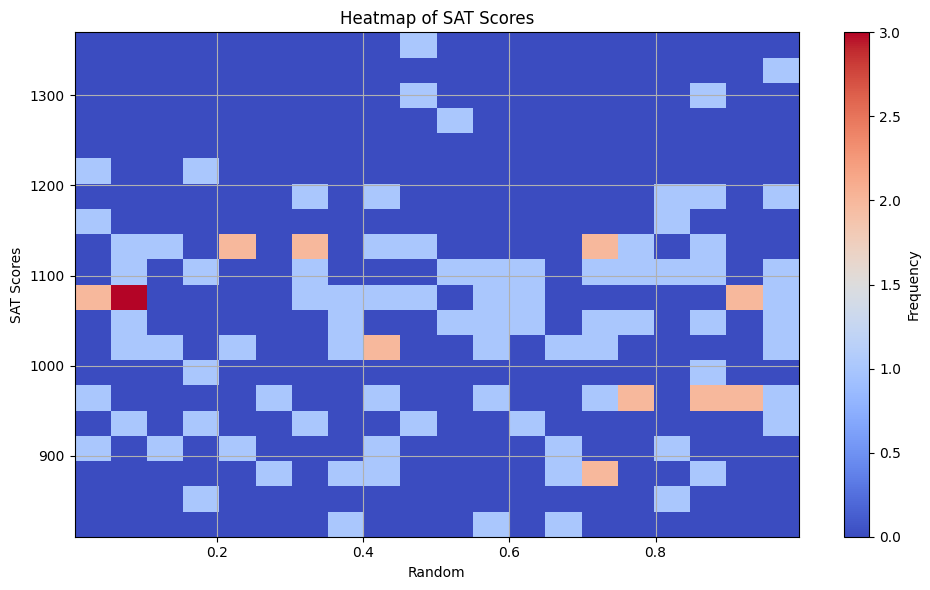

In [11]:
# Retrieve data from MongoDB
sat_scores = []
for document in scores.find({}, {"SAT_Total": 1}):  # Only retrieve SAT scores
    score = float(document.get('SAT_Total'))  # Convert to float
    sat_scores.append(score)

plt.figure(figsize=(10, 6))
plt.hist2d(np.random.rand(len(sat_scores)), sat_scores, bins=20, cmap='coolwarm')  # Adjust bins as needed
plt.colorbar(label='Frequency')
plt.xlabel('Random')
plt.ylabel('SAT Scores')
plt.title('Heatmap of SAT Scores')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Retrieve data from MongoDB
sat_scores = []
latitudes = []
longitudes = []
for document in scores.find({}, {"SAT_Total": 1, "Latitude": 1, "Longitude": 1}):
    score = float(document.get('SAT_Total'))
    latitude = float(document.get('Latitude'))
    longitude = float(document.get('Longitude'))
    sat_scores.append(score)
    latitudes.append(latitude)
    longitudes.append(longitude)

# Create a map centered around Texas

map_sat_scores = folium.Map(location=[31.9686, -99.9018], zoom_start=6)
# Create a colormap for the legend
colormap = linear.YlOrRd_09.scale(min(sat_scores), max(sat_scores))
colormap.caption = 'SAT Scores'

# Add heatmap layer with legend
heat_data = list(zip(latitudes, longitudes, sat_scores))
folium.plugins.HeatMap(heat_data, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(map_sat_scores)
map_sat_scores.add_child(colormap)

# Display the map
map_sat_scores

In [28]:
# Retrieve data from MongoDB
act_scores = []
latitudes = []
longitudes = []
for document in scores.find({}, {"ACT_Compos": 1, "Latitude": 1, "Longitude": 1}):
    score = float(document.get('ACT_Compos'))
    latitude = float(document.get('Latitude'))
    longitude = float(document.get('Longitude'))
    act_scores.append(score)
    latitudes.append(latitude)
    longitudes.append(longitude)

# Create a map centered around Texas

map_act_scores = folium.Map(location=[31.9686, -99.9018], zoom_start=6)
# Create a colormap for the legend
colormap = linear.YlOrRd_09.scale(min(act_scores), max(act_scores))
colormap.caption = 'ACT Scores'

# Add heatmap layer with legend
heat_data = list(zip(latitudes, longitudes, act_scores))
folium.plugins.HeatMap(heat_data, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(map_act_scores)
map_act_scores.add_child(colormap)

# Display the map
map_act_scores